# Data Preprocessing

In [64]:
from torch.utils.data import DataLoader, Dataset
from torchinfo import summary
import torch.optim as optim
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
from tqdm import tqdm
import pandas as pd
import os
import numpy as np
import itertools
import matplotlib.pyplot as plt
import random

In [65]:
# Folder containing CSVs with sequences of loss values
folder_path = r'C:\Users\daV\Documents\ZHAW\HS 2024\dPoDL\dPoDL\experiments\filtered-search\cnns\cifar10\categorical'
input_window = 9
output_window = 1   # min 1

sequences = []

# Load all CSVs and extract sequences of loss values
for filename in [i for i in os.listdir(folder_path) if i.endswith(".csv")]:
    if filename.endswith(".csv"):
        file_path = os.path.join(folder_path, filename)
        try:
            data = pd.read_csv(file_path)
            if len(data) >= input_window + output_window: 
                values_temp = data['Loss'].values
                if max(values_temp) < 2 and min(values_temp) > 0:  # make sure data makes sense
                    sequences.append(values_temp)
        except:
            print(filename)

# crop to 60 values max
input_length = 60
sequences = [s if len(s) <= input_length else s[:input_length]for s in sequences]
flattened = list(itertools.chain(*sequences))
MEAN_GLOBAL, STD_GLOBAL = np.mean(flattened), np.std(flattened)
print("number of sequences:", len(sequences), "MEAN_GLOBAL:", MEAN_GLOBAL, "STD_GLOBAL:", STD_GLOBAL)

number of sequences: 332 MEAN_GLOBAL: 0.6728278730772329 STD_GLOBAL: 0.40318570563162165


### Data visualization

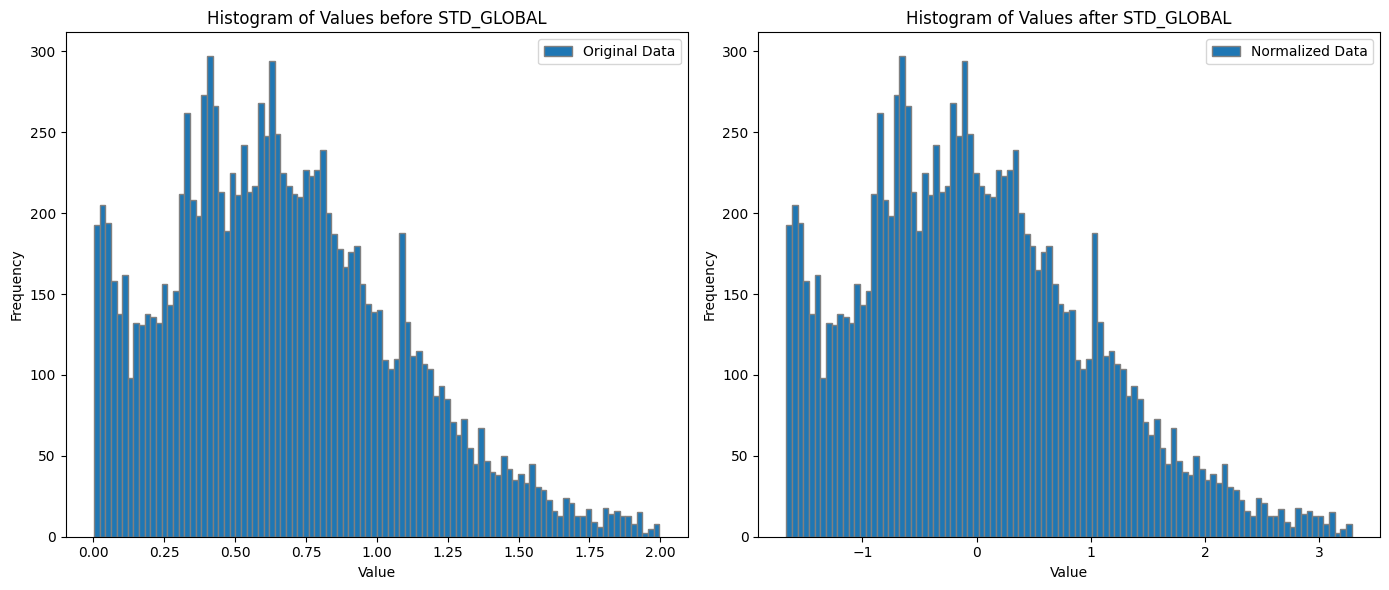

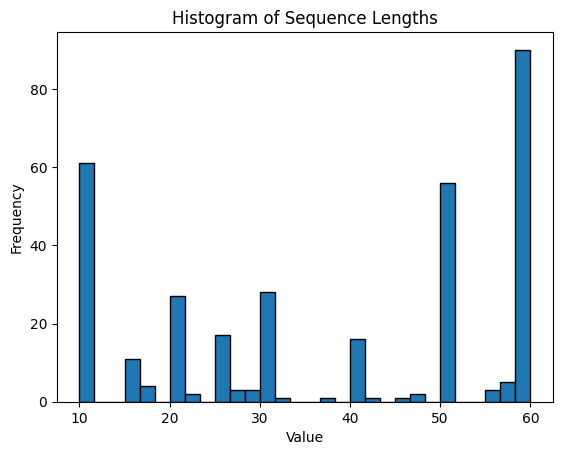

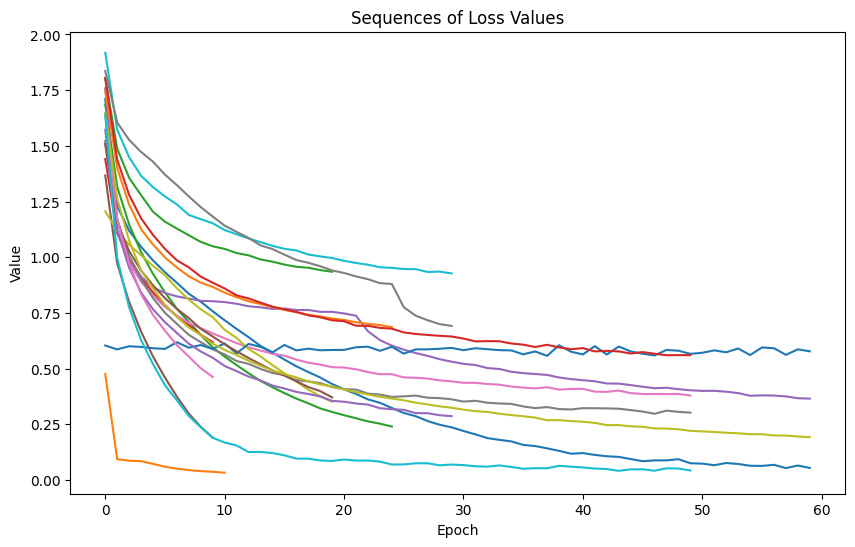

In [66]:
fig, ax = plt.subplots(1, 2, figsize=(14, 6))

ax[0].hist(flattened, bins=100, edgecolor="grey", label='Original Data')
ax[0].set_xlabel('Value')
ax[0].set_ylabel('Frequency')
ax[0].set_title('Histogram of Values before STD_GLOBAL')

ax[1].hist([(s-MEAN_GLOBAL)/STD_GLOBAL for s in flattened], bins=100, edgecolor="grey", label='Normalized Data')
ax[1].set_xlabel('Value')
ax[1].set_ylabel('Frequency')
ax[1].set_title('Histogram of Values after STD_GLOBAL')

ax[0].legend()
ax[1].legend()
plt.tight_layout()  # Adjust layout to prevent overlap
plt.show()

plt.hist([len(s) for s in sequences], bins=input_length//2, edgecolor='black')  
#plt.hist(flattened, bins=500, edgecolor='black')  
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.title('Histogram of Sequence Lengths')
plt.show()

plt.figure(figsize=(10, 6))
for seq in random.sample(sequences, k=20):
    plt.plot(seq)
plt.xlabel('Epoch')
plt.ylabel('Value')
plt.title('Sequences of Loss Values')
plt.show()

## Data preparation

In [67]:
train_split = 0.8
train_split_index = int(len(sequences) * train_split)
sequences_standardized = [(s-MEAN_GLOBAL)/STD_GLOBAL for s in sequences]
flattened_s = list(itertools.chain(*sequences_standardized))
print("new mean and std of standardized sequences:", np.mean(flattened_s), np.std(flattened_s))

train_sequences_not_augmented, test_sequences = sequences_standardized[:train_split_index], sequences_standardized[train_split_index:]
train_sequences = []
for seq in train_sequences_not_augmented:
    for ix in range(2, len(seq)+1):
        train_sequences.append(seq[:ix])
        
print("train samples:", len(train_sequences), "test samples (not augmented that's why fewer):", len(test_sequences))

new mean and std of standardized sequences: -2.0142630505561349e-16 1.0
train samples: 9889 test samples (not augmented that's why fewer): 67


In [68]:
class FloatSequenceDataset(Dataset):
    def __init__(self, sequences):
        """
        Args:
            sequences (list of lists): A list of sequences, where each sequence is a list of floats.
        """
        self.data = sequences

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        sequence = self.data[idx]
        inputs = torch.tensor(sequence[:-1], dtype=torch.float32).unsqueeze(-1)  # All but the last value
        target = torch.tensor(sequence[-1], dtype=torch.float32)  # Last value is the target
        return inputs, target

# Collate function to handle variable-length sequences
def collate_variable_length(batch):
    inputs, targets = zip(*batch)
    lengths = [seq.size(0) for seq in inputs]

    # Pad inputs
    padded_inputs = torch.zeros(len(inputs), input_length, 1)
    for i, seq in enumerate(inputs):
        padded_inputs[i, :seq.size(0)] = seq

    # Generate 2D key padding mask (batch_size, input_length)
    key_padding_mask = torch.full((len(inputs), input_length), True, dtype=torch.bool)  # Start with all True (padded positions)
    for i, length in enumerate(lengths):
        key_padding_mask[i, :length] = False

    targets = torch.stack(targets)
    return padded_inputs, targets, key_padding_mask


# Model Architecture

### Negative Log-Likelihood (NLL) Loss for a Gaussian Distribution

The **negative log-likelihood (NLL)** loss is given by:

$$
\text{NLL Loss} = \frac{1}{2} \left[ \log(\sigma^2) + \frac{(y - \mu)^2}{\sigma^2} \right]
$$

Where:
- $y$: Ground-truth target.
- $\mu$: Predicted mean.
- $\sigma^2 $: Predicted variance.

#### Components of the Loss:
1. $ \log(\sigma^2)$: Penalizes large variances, encouraging the model to make confident predictions.
2. $\frac{(y - \mu)^2}{\sigma^2}$: Measures the squared error normalized by variance, penalizing large deviations when variance is small.


In [79]:
###################################################
# custom loss functions that penalizes negative values (after de-standardizing)
###################################################

def custom_loss(predictions, targets):
    # Standard loss
    base_loss = base_loss_fn(predictions, targets)

    # De-standardize predictions
    de_standardized_preds = (predictions * STD_GLOBAL) + MEAN_GLOBAL

    # Add penalty for negative de-standardized predictions
    penalty = torch.mean(torch.relu(-de_standardized_preds))  # Relu ensures penalty is only for negatives

    return base_loss + (base_loss/(10*len(predictions))) * penalty  # make sure not big magnitud of 


def custom_loss_nll(predictions, targets):
    mean, log_var = predictions  # Predictions now include mean and log variance
    var = torch.exp(log_var)  # Ensure variance is positive

    # Negative log-likelihood loss
    nll_loss = 0.5 * (torch.log(var) + ((targets - mean) ** 2) / var)
    nll_loss = torch.mean(nll_loss)

    # Regularization term for variance
    variance_reg = torch.mean(var)  # Penalize large variance values
    variance_reg_weight = 0.1  # Small weight for regularization term

    # Final loss includes variance regularization
    return nll_loss + variance_reg_weight * variance_reg




###################################################
# Custom Transformer Class
###################################################
class FloatSequenceTransformer(nn.Module):
    def __init__(self, embedding_dim=32, num_heads=1, num_layers=1, dropout=0.2):
        super(FloatSequenceTransformer, self).__init__()
        
        self.embedding = nn.Linear(1, embedding_dim)
        self.embedding_dim = embedding_dim

        transformer_layer = nn.TransformerEncoderLayer(d_model=embedding_dim, nhead=num_heads, 
                                                       batch_first=True, dropout=dropout)
        self.transformer = nn.TransformerEncoder(transformer_layer, num_layers=num_layers)
        
        self.output_layer = nn.Linear(embedding_dim, 1)  # NO UNCERTAINTY
        #self.output_layer = nn.Linear(embedding_dim, 2)

    def generate_positional_encoding(self, seq_length, device):
        position = torch.arange(seq_length, device=device).unsqueeze(1).float()
        div_term = torch.exp(torch.arange(0, self.embedding_dim, 2, device=device).float() * -(np.log(10000.0) / self.embedding_dim))
        pe = torch.zeros(seq_length, self.embedding_dim, device=device)
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        return pe
    
    def forward(self, x, key_padding_mask):
        seq_length = x.size(1)
        x = self.embedding(x)
        positional_encoding = self.generate_positional_encoding(seq_length, x.device)
        x = x + 0.1 * positional_encoding # maybe positional encoding too heavily weighted!
    
        # Pass the 2D key_padding_mask
        x = self.transformer(x, src_key_padding_mask=key_padding_mask)
        x = self.output_layer(x)
        #mean, log_var = x[:, -1, 0], x[:, -1, 1]
        #return mean, log_var
        # NO UNCERTAINITY
        return  x[:, -1, :]

###################################################
# weight initialization strategy
###################################################
def init_weights(m):
    if isinstance(m, nn.Linear):
        nn.init.xavier_uniform_(m.weight)
        if m.bias is not None:
            nn.init.zeros_(m.bias)
    elif isinstance(m, nn.Embedding):
        nn.init.normal_(m.weight, mean=0, std=0.01)  # Initialize embeddings
    elif isinstance(m, nn.TransformerEncoderLayer):
        for param in m.parameters():
            if param.dim() > 1:
                nn.init.xavier_uniform_(param)  # Initialize weights in transformer layers


In [90]:
# Instantiate model, loss, and optimizer
model = FloatSequenceTransformer() 
base_loss_fn = nn.SmoothL1Loss()
criterion = custom_loss    #custom_loss  or  nn.SmoothL1Loss()  nn.MSELoss()-> more sensitive to outliers, worse results
#criterion = nn.SmoothL1Loss()    #custom_loss  or  nn.SmoothL1Loss()  nn.MSELoss()-> more sensitive to outliers, worse results
optimizer = optim.AdamW(model.parameters(), lr=0.001)  
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.5)  # Halve LR every 2 epochs
clip_value = 10.0 
patience = 3  # number of epochs without improvement

dataset = FloatSequenceDataset(train_sequences)
dataloader = DataLoader(dataset, batch_size=32, shuffle=True, collate_fn=lambda x: collate_variable_length(x))

model.apply(init_weights)
summary(model)

Layer (type:depth-idx)                                            Param #
FloatSequenceTransformer                                          --
├─Linear: 1-1                                                     64
├─TransformerEncoder: 1-2                                         --
│    └─ModuleList: 2-1                                            --
│    │    └─TransformerEncoderLayer: 3-1                          137,504
├─Linear: 1-3                                                     33
Total params: 137,601
Trainable params: 137,601
Non-trainable params: 0

### Hparams results:
- **Learning Rate:**
    - **0.01**: lowest loss value at 0.0147. Most significant improvement after first epoch, then oscillitating, no more progress. _Sequence of loss values:  [0.1065, 0.0265, 0.0232, 0.0266, 0.0220, 0.0197, 0.0187, 0.0170, 0.0186, 0.0188, 0.0147, 0.0160, 0.0222]_
    - **0.001**: lowest loss value at 0.0129. Most significant improvement after first epoch, then oscillitating, no more progress. _Sequence of loss values:  [0.0694, 0.0271, 0.0242, 0.0227, 0.0212, 0.0201, 0.0188, 0.0165, 0.0170, 0.0160, 0.0146, 0.0140, 0.0142, 0.0135, 0.0130, 0.0129, 0.0135, 0.0134]_

## Training

In [91]:
num_epochs = 40

best_loss = float("inf")
for epoch in range(num_epochs):
    model.train()
    epoch_loss = 0.0

    for inputs, targets, key_padding_mask in tqdm(dataloader):
        targets = targets.unsqueeze(1)
        optimizer.zero_grad()
        predictions = model(inputs, key_padding_mask)

        loss = criterion(predictions, targets)

        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), clip_value)
        optimizer.step()

        epoch_loss += loss.item()

    avg_loss = epoch_loss / len(dataloader)
    # Early stopping check
    if avg_loss < best_loss:
        best_loss = avg_loss
        epochs_without_improvement = 0  # Reset counter if loss improved
    else:
        epochs_without_improvement += 1

    # If no improvement for `patience` epochs, stop training
    if epochs_without_improvement >= patience:
        print(f"Early stopping triggered at epoch {epoch + 1}.")
        break
    
    scheduler.step()
    print(f"Epoch {epoch + 1}/{num_epochs}, Loss: {epoch_loss / len(dataloader):.4f}")


100%|████████████████████████████████████████████████████████████████████████████████| 310/310 [00:16<00:00, 19.01it/s]


Epoch 1/40, Loss: 0.0694


100%|████████████████████████████████████████████████████████████████████████████████| 310/310 [00:20<00:00, 14.85it/s]


Epoch 2/40, Loss: 0.0271


100%|████████████████████████████████████████████████████████████████████████████████| 310/310 [00:20<00:00, 15.10it/s]


Epoch 3/40, Loss: 0.0242


100%|████████████████████████████████████████████████████████████████████████████████| 310/310 [00:21<00:00, 14.62it/s]


Epoch 4/40, Loss: 0.0227


100%|████████████████████████████████████████████████████████████████████████████████| 310/310 [00:20<00:00, 14.81it/s]


Epoch 5/40, Loss: 0.0212


100%|████████████████████████████████████████████████████████████████████████████████| 310/310 [00:20<00:00, 14.96it/s]


Epoch 6/40, Loss: 0.0201


100%|████████████████████████████████████████████████████████████████████████████████| 310/310 [00:20<00:00, 14.92it/s]


Epoch 7/40, Loss: 0.0188


100%|████████████████████████████████████████████████████████████████████████████████| 310/310 [00:32<00:00,  9.49it/s]


Epoch 8/40, Loss: 0.0165


100%|████████████████████████████████████████████████████████████████████████████████| 310/310 [00:27<00:00, 11.44it/s]


Epoch 9/40, Loss: 0.0170


100%|████████████████████████████████████████████████████████████████████████████████| 310/310 [00:27<00:00, 11.26it/s]


Epoch 10/40, Loss: 0.0160


100%|████████████████████████████████████████████████████████████████████████████████| 310/310 [00:25<00:00, 11.92it/s]


Epoch 11/40, Loss: 0.0146


100%|████████████████████████████████████████████████████████████████████████████████| 310/310 [00:21<00:00, 14.38it/s]


Epoch 12/40, Loss: 0.0140


100%|████████████████████████████████████████████████████████████████████████████████| 310/310 [00:24<00:00, 12.49it/s]


Epoch 13/40, Loss: 0.0142


100%|████████████████████████████████████████████████████████████████████████████████| 310/310 [00:26<00:00, 11.58it/s]


Epoch 14/40, Loss: 0.0135


100%|████████████████████████████████████████████████████████████████████████████████| 310/310 [00:21<00:00, 14.37it/s]


Epoch 15/40, Loss: 0.0130


100%|████████████████████████████████████████████████████████████████████████████████| 310/310 [00:23<00:00, 13.25it/s]


Epoch 16/40, Loss: 0.0129


100%|████████████████████████████████████████████████████████████████████████████████| 310/310 [00:25<00:00, 12.02it/s]


Epoch 17/40, Loss: 0.0135


100%|████████████████████████████████████████████████████████████████████████████████| 310/310 [00:22<00:00, 13.72it/s]


Epoch 18/40, Loss: 0.0134


100%|████████████████████████████████████████████████████████████████████████████████| 310/310 [00:23<00:00, 13.07it/s]

Early stopping triggered at epoch 19.


## Test trained model

In [122]:
def predict_next_value(model, sequence):
    model.eval()
    with torch.no_grad():
        # Prepare the input sequence
        input_sequence = torch.tensor(sequence, dtype=torch.float32).unsqueeze(-1)  # Shape: (seq_length, 1)
        padded_input = torch.zeros(input_length, 1)  # Padding to fixed length
        padded_input[:len(sequence)] = input_sequence  # Copy sequence into padded tensor

        # Create the key_padding_mask
        key_padding_mask = torch.full((1, input_length), True, dtype=torch.bool)  # All True initially
        key_padding_mask[0, :len(sequence)] = False  # False for valid positions

        # Make the prediction
        padded_input = padded_input.unsqueeze(0)  # Add batch dimension: (1, input_length, 1)
        
        #mean, log_var = model(padded_input, key_padding_mask)
        #uncertainty = torch.sqrt(torch.exp(log_var)).item()
        #return mean.item(), uncertainty
        # NO UNCERTAINTY
        prediction = model(padded_input, key_padding_mask)
        return prediction.item()

# test uncertainty of model
def predict_next_value_with_uncertainty(model, sequence, num_samples=100):
    model.train()  # Set the model to training mode (this keeps dropout active)
    predictions = []

    # Prepare the input sequence
    input_sequence = torch.tensor(sequence, dtype=torch.float32).unsqueeze(-1)  # Shape: (seq_length, 1)
    padded_input = torch.zeros(input_length, 1)  # Padding to fixed length
    padded_input[:len(sequence)] = input_sequence  # Copy sequence into padded tensor

    # Create the key_padding_mask
    key_padding_mask = torch.full((1, input_length), True, dtype=torch.bool)  # All True initially
    key_padding_mask[0, :len(sequence)] = False  # False for valid positions

    # Make the prediction
    padded_input = padded_input.unsqueeze(0)  # Add batch dimension: (1, input_length, 1)

    prediction = model(padded_input, key_padding_mask)

    with torch.no_grad():  # Disable gradient computation during inference
        for _ in range(num_samples):
            # Perform forward pass with dropout enabled
            prediction = model(padded_input, key_padding_mask)
            predictions.append(prediction.item())  # Store the predictions (detached from the computation graph)
    
    predictions = np.array(predictions)
    mean_prediction = predictions.mean(axis=0)  # Mean prediction across samples
    std_prediction  = predictions.std(axis=0)  # Standard deviation as uncertainty
    
    return mean_prediction, std_prediction


In [127]:
results_hallucinate = []
input_window = 3 # even good results with 3!
for sequence in tqdm([_ for _ in test_sequences if len(_) > input_window + 5]): 
    real_sequence, predicted_sequence, std_predictions = sequence, list(sequence[:input_window]), [0] * input_window
                                                                             
    for i in range(input_window, len(sequence)):
        if i == input_window:
            previous_input = sequence[:input_window]
        y_hat, std_prediction = predict_next_value_with_uncertainty(model, previous_input, num_samples=30)
        #y_hat = predict_next_value(model, previous_input)
        previous_input = np.concatenate((previous_input, np.array([y_hat])))
        std_predictions.append(std_prediction)
        
    predicted_sequence = previous_input
    real_sequence, predicted_sequence = real_sequence * STD_GLOBAL + MEAN_GLOBAL, predicted_sequence * STD_GLOBAL + MEAN_GLOBAL
    results_hallucinate.append((real_sequence, predicted_sequence, std_predictions))

KeyboardInterrupt: 

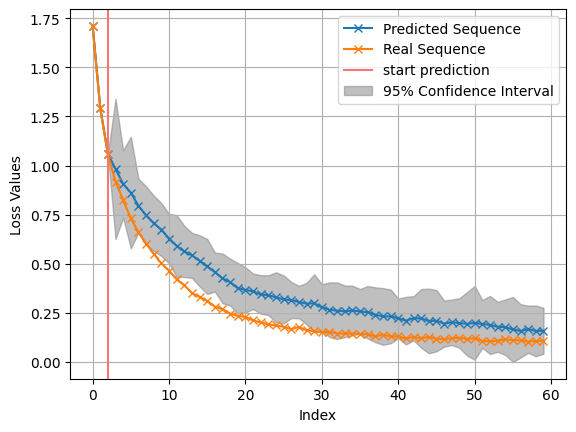

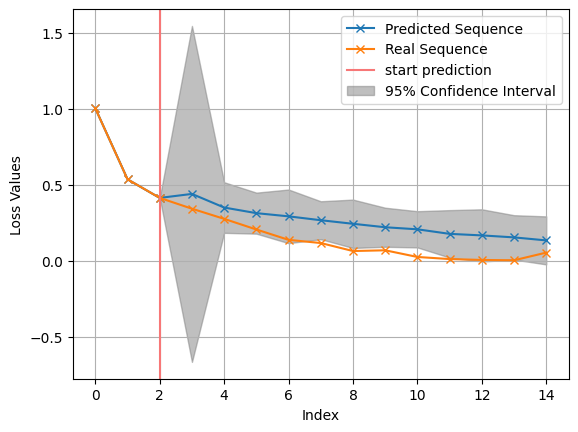

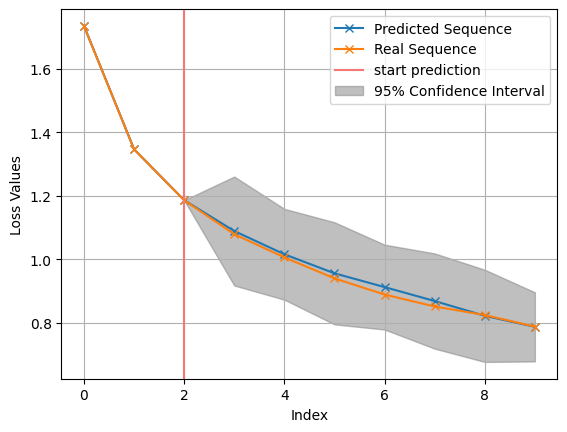

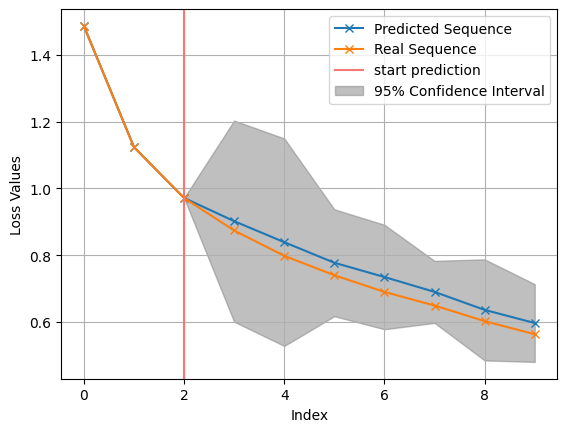

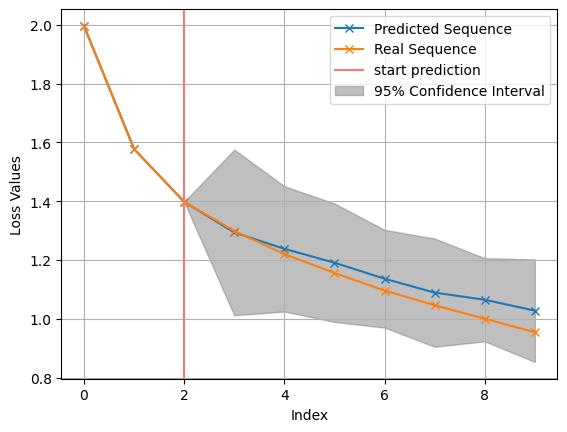

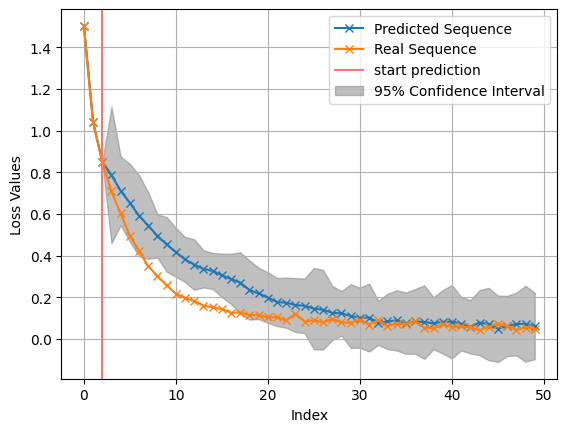

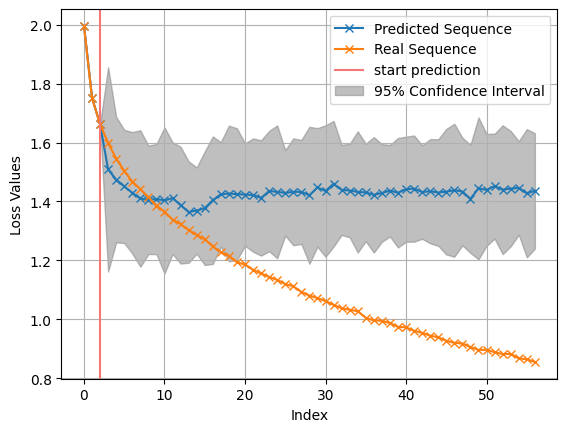

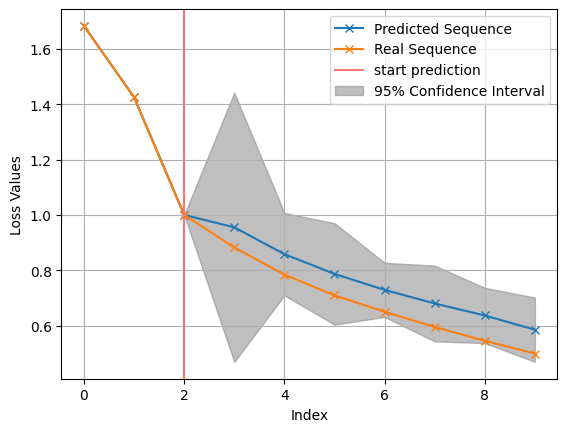

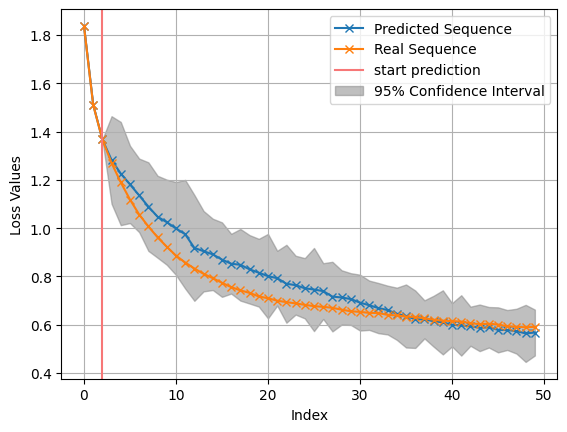

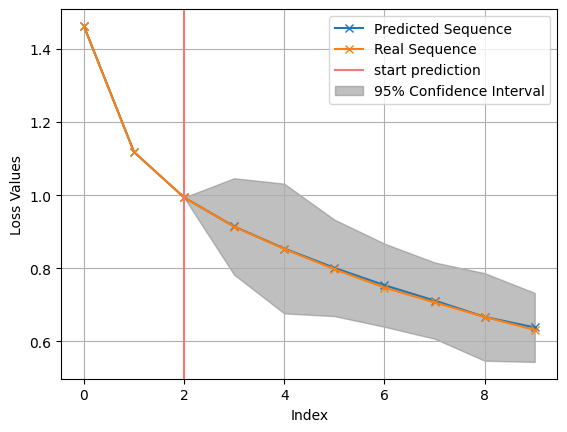

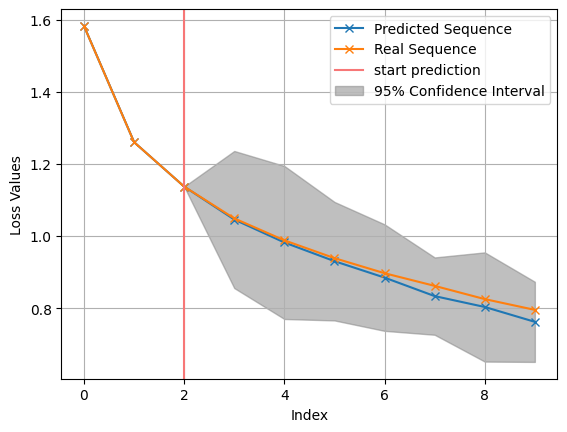

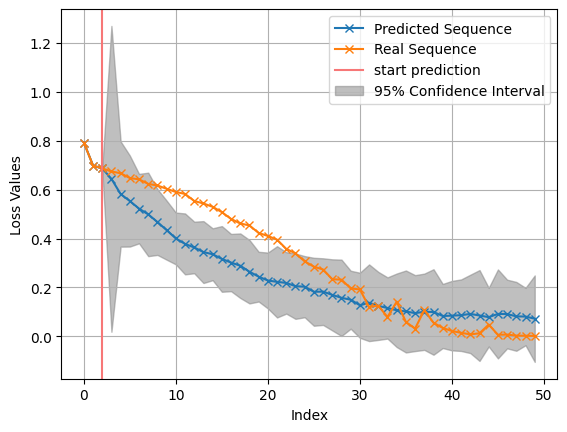

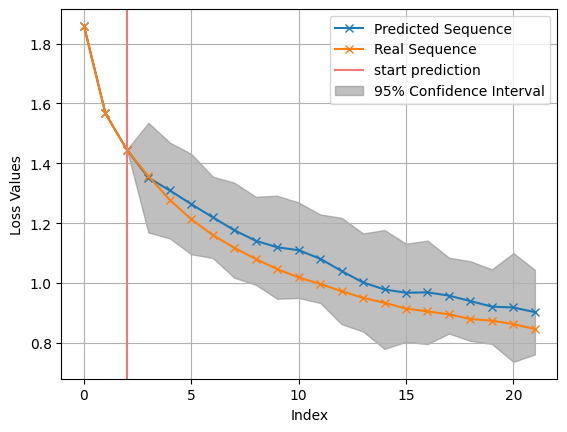

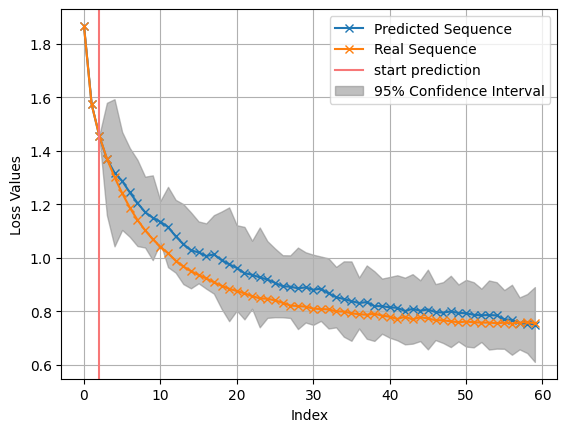

In [128]:
num_samples = 14

sample = random.sample(results_hallucinate, num_samples)
for i, (real_sequence, predicted_sequence, std_predictions) in enumerate(sample):
    std_predictions = [0 if i is None else i for i in std_predictions]
    ci_lower, ci_upper = np.array(predicted_sequence) - 1.96 * np.array(std_predictions), np.array(predicted_sequence) + 1.96 * np.array(std_predictions)
    plt.figure()
    plt.plot(predicted_sequence, label="Predicted Sequence", marker='x', linestyle='-')
    plt.plot(real_sequence, label="Real Sequence", marker='x', linestyle='-')
    plt.axvline(x=input_window-1, color='#f77777', linestyle='-', label="start prediction")

    plt.fill_between(range(len(predicted_sequence)), ci_lower, ci_upper, color='gray', alpha=0.5, label="95% Confidence Interval")
    
    plt.xlabel("Index")
    plt.ylabel("Loss Values")
    plt.legend()
    plt.grid()
    plt.show()

In [116]:
ix = 2
t = test_sequences[ix]
mean_prediction, std_prediction = predict_with_uncertainty(model, t[:-1])
print("mean_prediction:", mean_prediction, "true value:",  t[-1], "std_prediction:", std_prediction)

mean_prediction: -1.4214890774091085 true value: -1.3128636895695491 std_prediction: 0.08127181832225985


In [92]:
model_save_path = "models/trained_model_variable_length.pth"

# Save the model's state dictionary
torch.save(model.state_dict(), model_save_path)
print(f"Model saved to {model_save_path}")

Model saved to models/trained_model_variable_length.pth
